# 2023 Immune dataset H3K36me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps an active gene (defined varying RPKM from 0 to 2)
and compared methods based on sensitivity, precision and F-score.

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune


In [70]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
from itertools import product

In [71]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [72]:
PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
! mkdir -p {PATH}/pics

## Load hg38 gtf file

In [73]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

chromosome      db         type      start        end point1 strand  \
122804        chr1  HAVANA         exon   66833991   66834148      .      -   
1882975      chr11  HAVANA         exon   64800764   64800826      .      -   
2129023      chr12  HAVANA         exon  108547887  108547991      .      -   
1083531       chr6  HAVANA          UTR    3019653    3019755      .      +   
736441        chr3  HAVANA  start_codon  148865308  148865310      .      +   
283624        chr1  HAVANA          CDS  223223249  223223631      .      -   
2937811      chr19  HAVANA         gene   15615218   15630639      .      +   
895730        chr4  HAVANA         exon  139602683  139602757      .      -   
2763467      chr17  HAVANA         exon   63494372   63494470      .      +   
163980        chr1  HAVANA         exon  112699663  112699810      .      +   

        point2                                                aux  
122804       .  gene_id "ENSG00000152763.17"; transcript_id "E...  
1882975      .  gene_id "ENSG00000168067.12"; transcript_id "E...  
2129023      .  gene_id "ENSG00000075856.12"; transcript_id "E...  
1083531      .  gene_id "ENSG00000124588.22"; transcript_id "E...  
736441       0  gene_id "ENSG00000163751.4"; transcript_id "EN...  
283624       1  gene_id "ENSG00000143502.16"; transcript_id "E...  
2937811      .  gene_id "ENSG00000186526.13"; gene_type "prote...  
895730       .  gene_id "ENSG00000145391.14"; transcript_id "E...  
2763467      .  gene_id "ENSG00000264813.6"; transcript_id "EN...  
163980       .  gene_id "ENSG00000155363.19"; transcript_id "E...

In [74]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [75]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


chromosome       db  type      start        end point1 strand point2  \
2310149      chr14   HAVANA  gene   81661428   81662874      .      +      .   
858662        chr4   HAVANA  gene   88709298   88730103      .      +      .   
2908525      chr19   HAVANA  gene    9363020    9382617      .      +      .   
411566        chr2   HAVANA  gene   91580336   91580863      .      +      .   
1048773       chr5  ENSEMBL  gene  151477459  151477577      .      -      .   

                 gene_id             gene_type        gene_name level  
2310149  ENSG00000258841  processed_pseudogene         EEF1A1P2     1  
858662   ENSG00000248019                lncRNA       FAM13A-AS1     2  
2908525  ENSG00000188629        protein_coding           ZNF177     1  
411566   ENSG00000261600                lncRNA  ENSG00000261600     2  
1048773  ENSG00000200227       rRNA_pseudogene        RNA5SP197     3

## Annotatate RNA-seq tables with positions

In [76]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [77]:
import re

EXPRESSION_TSV = {
    'BCell': PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    'TCell': PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    'Monocyte': PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}
THRESHOLD = 0.1

EXPRESSION_BED = {}
EXPRESSED_GENES = {}

for cell, path in EXPRESSION_TSV.items():
    print(cell, path)
    t = pd.read_csv(path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    # plt.figure(figsize=(10, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(data=t, x='LTPM', ax=ax,
    #                          stat='density',
    #                          kde=True, alpha=0.4)
    # ax.axvline(x=THRESHOLD, color='green')
    # ax.title.set_text(f'{cell} expression')
    # plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]

    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')
    EXPRESSED_GENES[cell] = len(full_df)

    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = path.replace('.tsv', f'_tpm{THRESHOLD}.bed')
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_BED[cell] = expr_path


BCell /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv
Total genes with positions 58387
Genes logTPM > 0.1 20769
Merging overlapping regions 20769
Reduced to 15121
Saved expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1.bed
TCell /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv
Total genes with positions 58387
Genes logTPM > 0.1 21110
Merging overlapping regions 21110
Reduced to 15303
Saved expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1.bed
Monocyte /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv
Total genes with positions 58387
Genes logTPM > 0.1 18584
Merging overlapping regions 18584
Reduced to 13519
Saved expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm0.1.bed


## Load peaks

In [78]:
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K36me3']

def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr

In [79]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 3


file modification      cell  \
2  /home/jetbrains/data/2023_Immune/macs2/BCell_H...     H3K36me3     BCell   
1  /home/jetbrains/data/2023_Immune/sicer/TCell_H...     H3K36me3     TCell   
1  /home/jetbrains/data/2023_Immune/macs2/TCell_H...     H3K36me3     TCell   
2  /home/jetbrains/data/2023_Immune/sicer/Monocyt...     H3K36me3  Monocyte   
1  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3     BCell   

    fdr   peaks      avlength   tool  
2  0.05  177956    992.056643  MACS2  
1  0.01   32491  10544.369487  SICER  
1  0.05  183613    881.151106  MACS2  
2  0.01   31796   9650.943641  SICER  
1  0.05   42693   8934.517813   SPAN

In [80]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER' , 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number

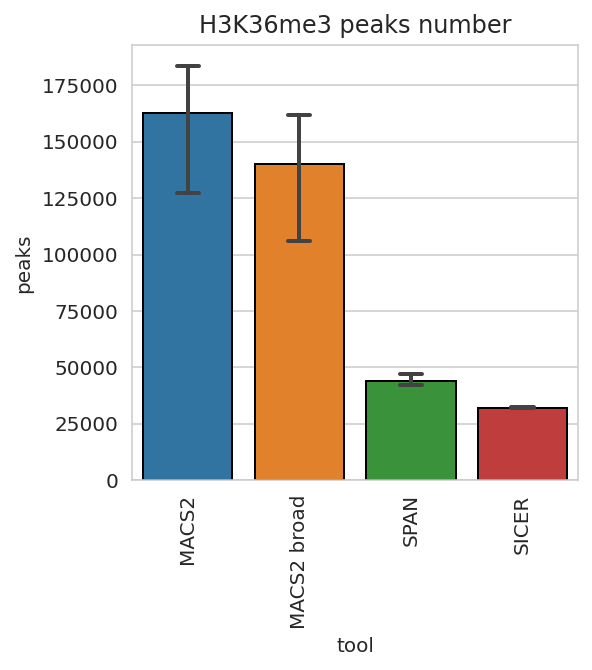

In [81]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K36me3 peaks number')
plt.show()

In [82]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(3)

0it [00:00, ?it/s]

tool   coverage
10   SPAN  381441369
11   SPAN  320118408
0   MACS2  167040107

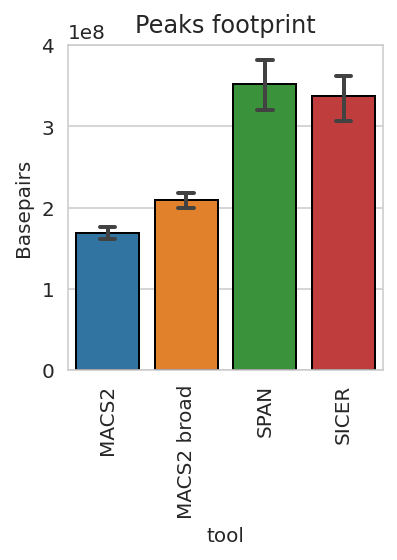

In [83]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Expressed genes vs peaks lengths

In [104]:
print('Load lengths')
ts = []
for cell in IMMUNE_CELLS:
    t = pd.read_csv(EXPRESSION_BED[cell], sep='\t',
                    names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM'])
    t = pd.DataFrame(dict(length=t['end']-t['start']))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['name'] = 'Genes'
    ts.append(t)
for cell, file, tool in tqdm(zip(df_fdr_peaks['cell'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length      cell         name
147347    2676  Monocyte         SPAN
5693    236817     BCell        Genes
143310    3587  Monocyte         SPAN
42482      299     TCell        MACS2
26465    82150  Monocyte        Genes
144379    7639  Monocyte         SPAN
44036     1295     TCell        MACS2
63465      368  Monocyte  MACS2 broad
38200      563  Monocyte        MACS2
106807    5599     TCell        SICER

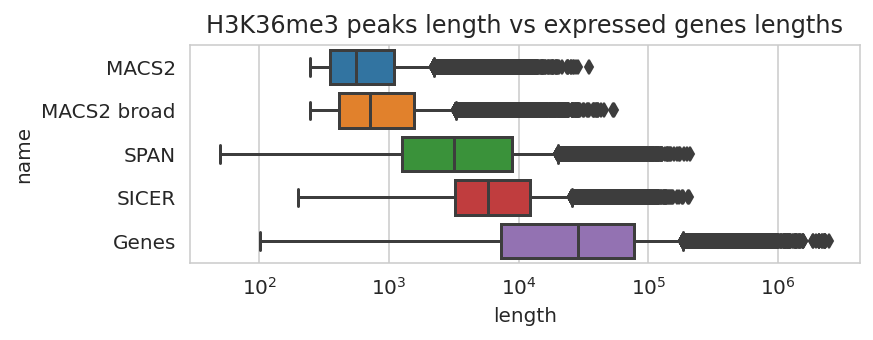

In [105]:
plt.figure(figsize=(6, 2))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='length', y='name', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER' , 'Genes'])
g_results.set(xscale='log')
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

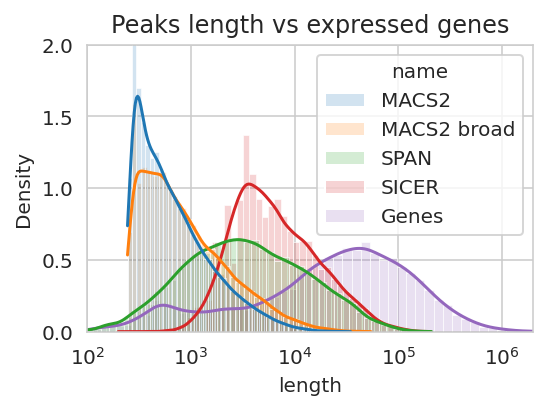

In [106]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER' , 'Genes'])
g_results.set(xscale='log')
g_results.set_ylim(0, 2)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('Peaks length vs expressed genes')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

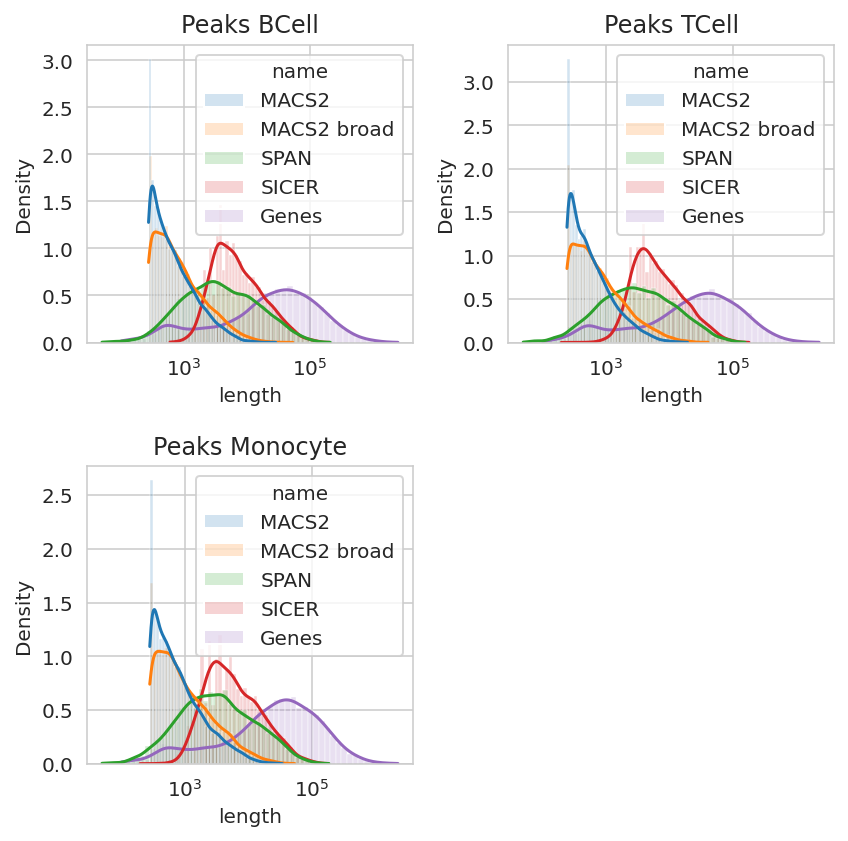

In [107]:
import math
experiments = [c for c in IMMUNE_CELLS if sum(t['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.histplot(data=t[t['cell'] == c],
                             x='length', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between narrow and broad peaks

In [102]:
! mkdir -p {PATH}/union

perc_ratio_df = pd.DataFrame(
    columns=['cell', 'length', 'tool', 'overlap_span_peaks', 'overlap_tool_peaks'], dtype=object)

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'length', 'tool', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    print(c)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{PATH}/union/H3K36me3_{c}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare SPAN percentage
            ! bedtools intersect -wa -u -a {t_span} -b {sorted_file(tf)} > {t_span}-perc
            # print('SPAN')
            # ! wc -l {t_span}-perc
            span_cols = len(pd.read_csv(f'{t_span}-perc', sep='\t', header=None, nrows=1).columns)
            # print('SPAN cols', span_cols)
            peak_lengths = bedl(f'{t_span}-perc')
            tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
            tl['cell'] = c
            tl['length'] = percentage_name
            tl['name'] = 'SPAN'
            perc_peaks_df.loc[len(perc_peaks_df)] = (c, percentage_name, 'SPAN', len(peak_lengths))
            perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SICER', t_sicer)]:
                # Prepare tool percentage
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['cell'] = c
                tl['length'] = percentage_name
                tl['name'] = tool
                perc_peaks_df.loc[len(perc_peaks_df)] = (c, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

                # print(tool)
                # ! wc -l {file}-perc
                ! bedtools intersect -a {t_span}-perc -b {file}-perc -wa -wb > {tf2}
                # print('Overlap')
                # ! wc -l {tf2}
                overlap = pd.read_csv(tf2, sep='\t', header=None)
                overlap_span_peaks = len(overlap.groupby([0, 1, 2]).count())
                overlap_tool_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
                perc_ratio_df.loc[len(perc_ratio_df)] = (c, percentage_name, tool, overlap_span_peaks, overlap_tool_peaks)
    except Exception as e:
        print(e)

display(perc_ratio_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell    length         tool  overlap_span_peaks  overlap_tool_peaks
16     TCell    0%-20%  MACS2 broad                3281                3312
27     TCell  80%-100%        MACS2               10704              140545
30  Monocyte    0%-20%        MACS2                 663                 668

peak_lengths      cell    length         name
33979           3337     BCell   40%-60%         SPAN
141718         20199     BCell  80%-100%        SICER
383409           783  Monocyte   60%-80%  MACS2 broad

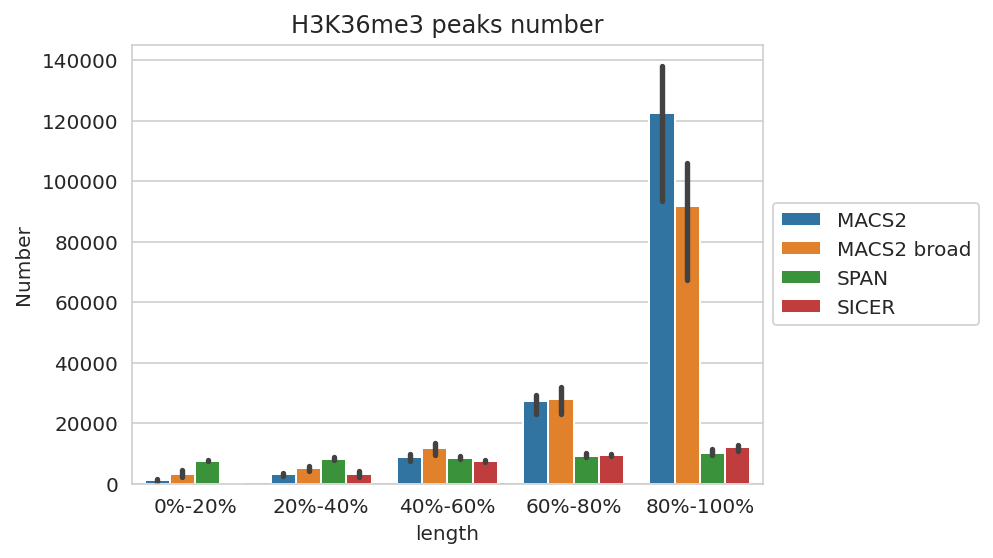

In [92]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K36me3 peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_peaks_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()


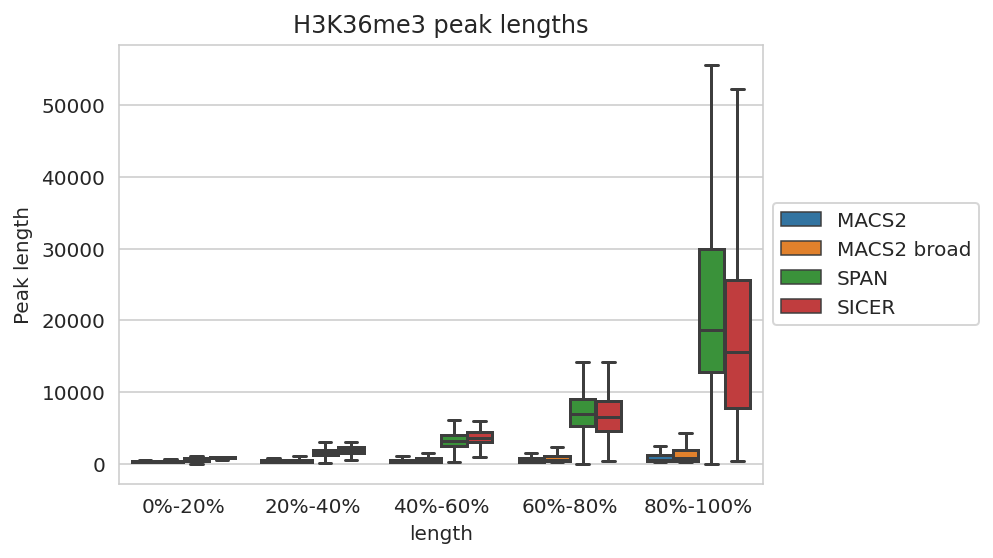

In [90]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K36me3 peak lengths')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_peak_length_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()


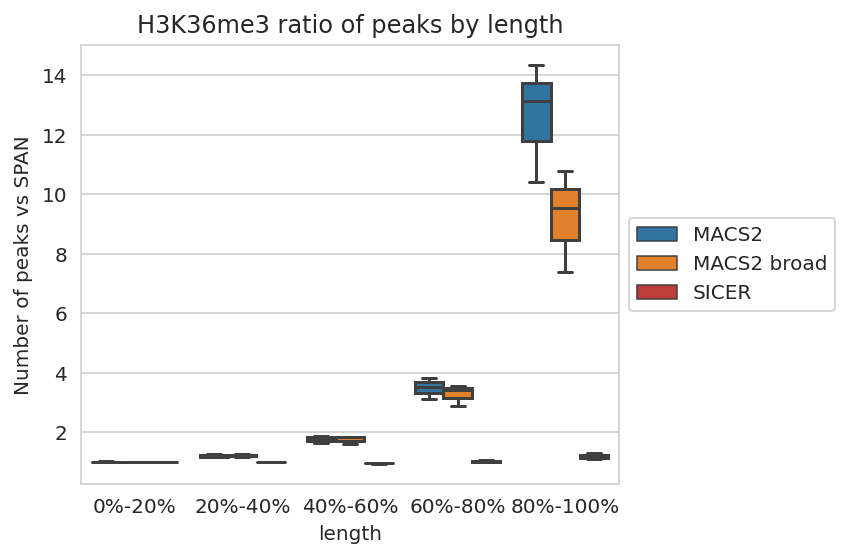

In [91]:
perc_ratio_df['tool_to_span'] = [d(t, s) for s, t in
                                 zip(perc_ratio_df['overlap_span_peaks'], perc_ratio_df['overlap_tool_peaks'])]

plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_ratio_df, x='length', y='tool_to_span', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K36me3 ratio of peaks by length')
g_results.axes.set_ylabel('Number of peaks vs SPAN')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_ratios_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Overlap H3K36me3 vs expressed genes

In [19]:
# Randomly tweak SICER lengths for visualization purposes
tsicer = t['name'] == 'SICER'
t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

In [20]:
tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len', 'genes', 'genes_len',
             'peaks_overlap', 'peaks_overlap_len', 'genes_overlap', 'genes_overlap_len'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u > {tf}
        genes_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {expr_file} -wo > {tf}
        peaks_overlap_len = genes_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, tool, peaks, peaks_len, genes, genes_len,
                                       peaks_overlap, peaks_overlap_len, genes_overlap, genes_overlap_len)
# bench_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


In [21]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['genes_overlap'], bench_df['genes'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['genes_overlap_len'], bench_df['genes_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['genes_len'], bench_df['genes_overlap_len'])
]

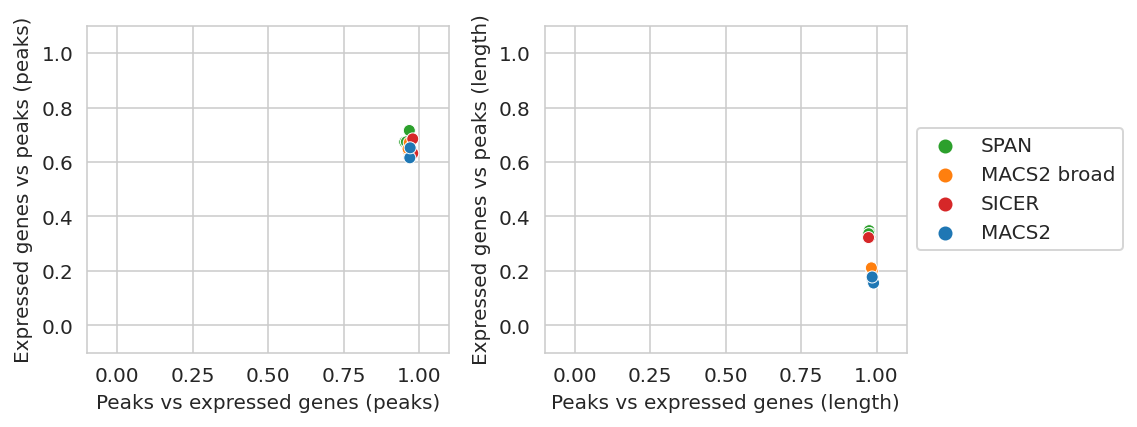

In [22]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs expressed genes (peaks)')
g_results.axes.set_ylabel('Expressed genes vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs expressed genes (length)')
g_results.axes.set_ylabel('Expressed genes vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [23]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
t.sort_values(by=['name'], inplace=True)
del ts

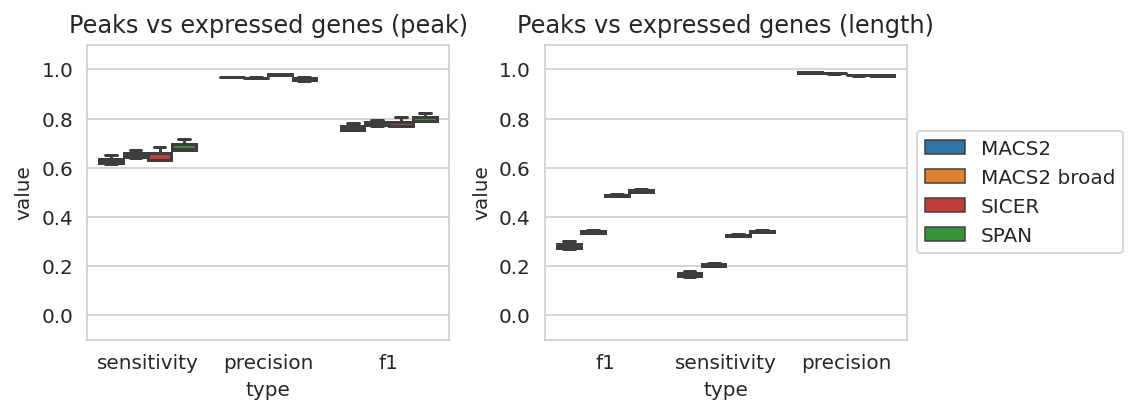

In [24]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name', palette=TOOLS_PALETTE, ax=axs[i])
    ax = g_results.axes
    ax.set_title(f'Peaks vs expressed genes ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K36me3 diff vs expressed genes

In [25]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len',
             'genes', 'genes_len',
             'peaks_overlap', 'peaks_overlap_len',
             'genes_overlap', 'genes_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c in tqdm(IMMUNE_CELLS):
    if (c) not in EXPRESSION_BED:
        continue
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {expr_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {expr_file} -wa -u > {tf2}
            genes_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {expr_file} -wo > {tf2}
            peaks_overlap_len = genes_overlap_len = int(last_col(tf2).sum())

            diff_bench_df.loc[len(diff_bench_df)] = \
                (c, name,
                 peaks, peaks_len,
                 genes, genes_len,
                 peaks_overlap, peaks_overlap_len,
                 genes_overlap, genes_overlap_len)

display(diff_bench_df.sample())

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell                name  peaks  peaks_len  genes  genes_len  \
15  Monocyte  MACS2 broad - SPAN     58      18339  13519  926772870   

    peaks_overlap  peaks_overlap_len  genes_overlap  genes_overlap_len  
15             53              17027             53              17027

In [26]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap'], diff_bench_df['genes'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])]
diff_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap_len'], diff_bench_df['genes_len'])]
diff_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                           for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])]

diff_bench_df['jaccard'] = [ d(o, p + g -o)
                             for p, g, o in zip(diff_bench_df['peaks_len'], diff_bench_df['genes_len'], diff_bench_df['genes_overlap_len'])
                             ]

In [27]:
full_bench_df = pd.concat([bench_df,diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

cell                name  peaks  peaks_len  genes   genes_len  \
4      TCell                SPAN  47042  355718056  15303  1030533965   
20     TCell  SPAN - MACS2 broad  11094   14997457  15303  1030533965   
16     BCell        SPAN - SICER  13742   17750607  15121  1070202389   
8   Monocyte                SPAN  42160  320118408  13519   926772870   
23     TCell        SICER - SPAN      9      36791  15303  1030533965   

    peaks_overlap  peaks_overlap_len  genes_overlap  genes_overlap_len  \
4           45080          347639518          10313          347639518   
20          10227           14197705           3620           14197705   
16          12411           16370019           4046           16370019   
8           40815          311777517           9674          311777517   
23              9              36791              9              36791   

    precision  sensitivity        f1  precision_len  sensitivity_len  \
4    0.958293     0.673920  0.791334       0.977289         0.337339   
20   0.921850     0.236555  0.376497       0.946674         0.013777   
16   0.903144     0.267575  0.412838       0.922223         0.015296   
8    0.968098     0.715585  0.822906       0.973944         0.336412   
23   1.000000     0.000588  0.001176       1.000000         0.000036   

      f1_len   jaccard  
4   0.501553  0.334715  
20  0.027159  0.013766  
16  0.030093  0.015276  
8   0.500088  0.333411  
23  0.000071  0.000036

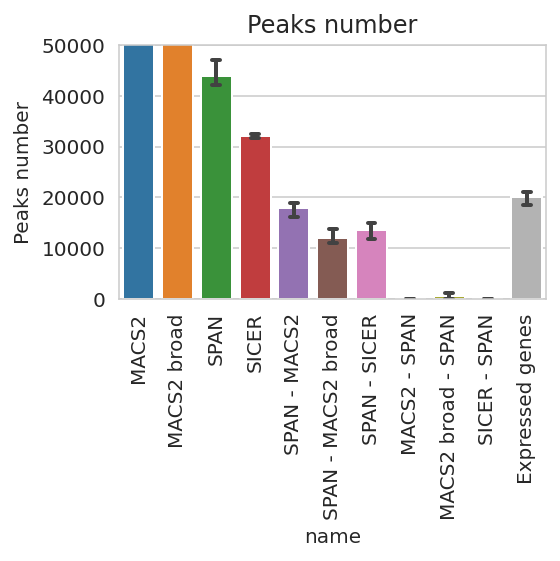

In [28]:
t = full_bench_df[['cell', 'name', 'peaks']].copy()
for cell in EXPRESSED_GENES.keys():
    t.loc[len(t)] = (cell, 'Expressed genes', EXPRESSED_GENES[cell])


palette = plt.cm.get_cmap('tab10')
TOOLS_GENES_PALETTE = {t: palette(i) for i, t in enumerate(
    ['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
     'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
     'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN']
)}
TOOLS_GENES_PALETTE['Expressed genes'] = (0.7, 0.7, 0.7, 1.0)

plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=t, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               'Expressed genes'
                               ],
                        palette=TOOLS_GENES_PALETTE
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
ax.set_ylim([0, 5e4]) # Limited for visual aesthetics
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

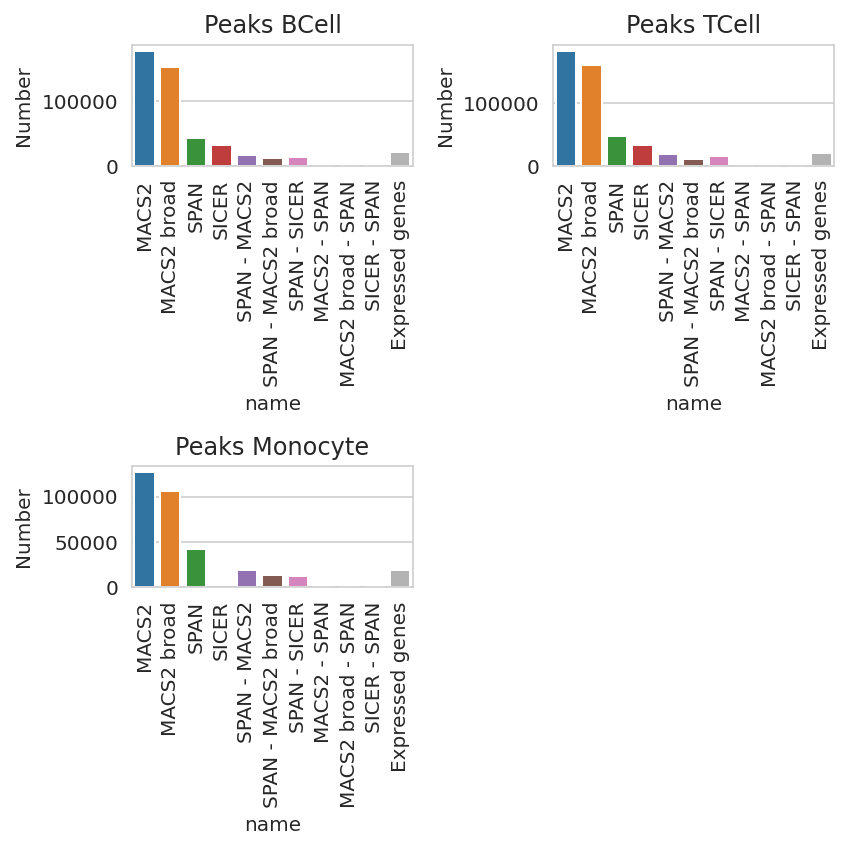

In [97]:
import math
experiments = [c for c in IMMUNE_CELLS
               if sum(full_bench_df['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    t = full_bench_df[full_bench_df['cell'] == c][['cell', 'name', 'peaks']].copy()
    t.loc[len(t)] = (c, 'Expressed genes', EXPRESSED_GENES[c])
    g_results = sns.barplot(data=t,
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'Expressed genes'
                                   ],
                            palette=TOOLS_GENES_PALETTE
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Save benchmark

In [29]:
t.to_csv(PATH + '/H3K36me3_full_bench_df.csv.gz', index=False, compression='gzip')

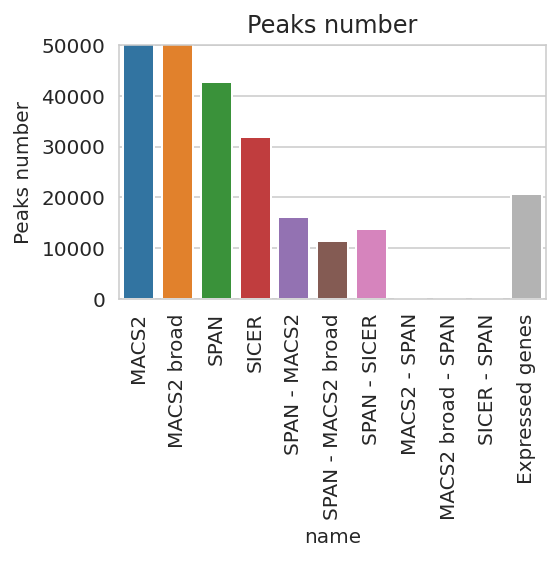

In [30]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=t[t['cell']=='BCell'], x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               'Expressed genes'
                               ],
                        palette=TOOLS_GENES_PALETTE
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
ax.set_ylim([0, 5e4]) # Limited for visual aesthetics
plt.tight_layout()
plt.show()

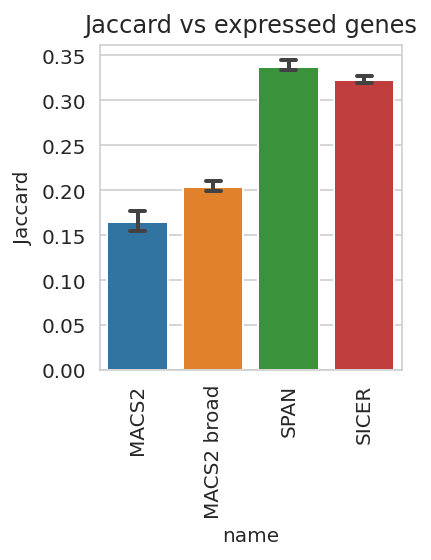

In [31]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [32]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

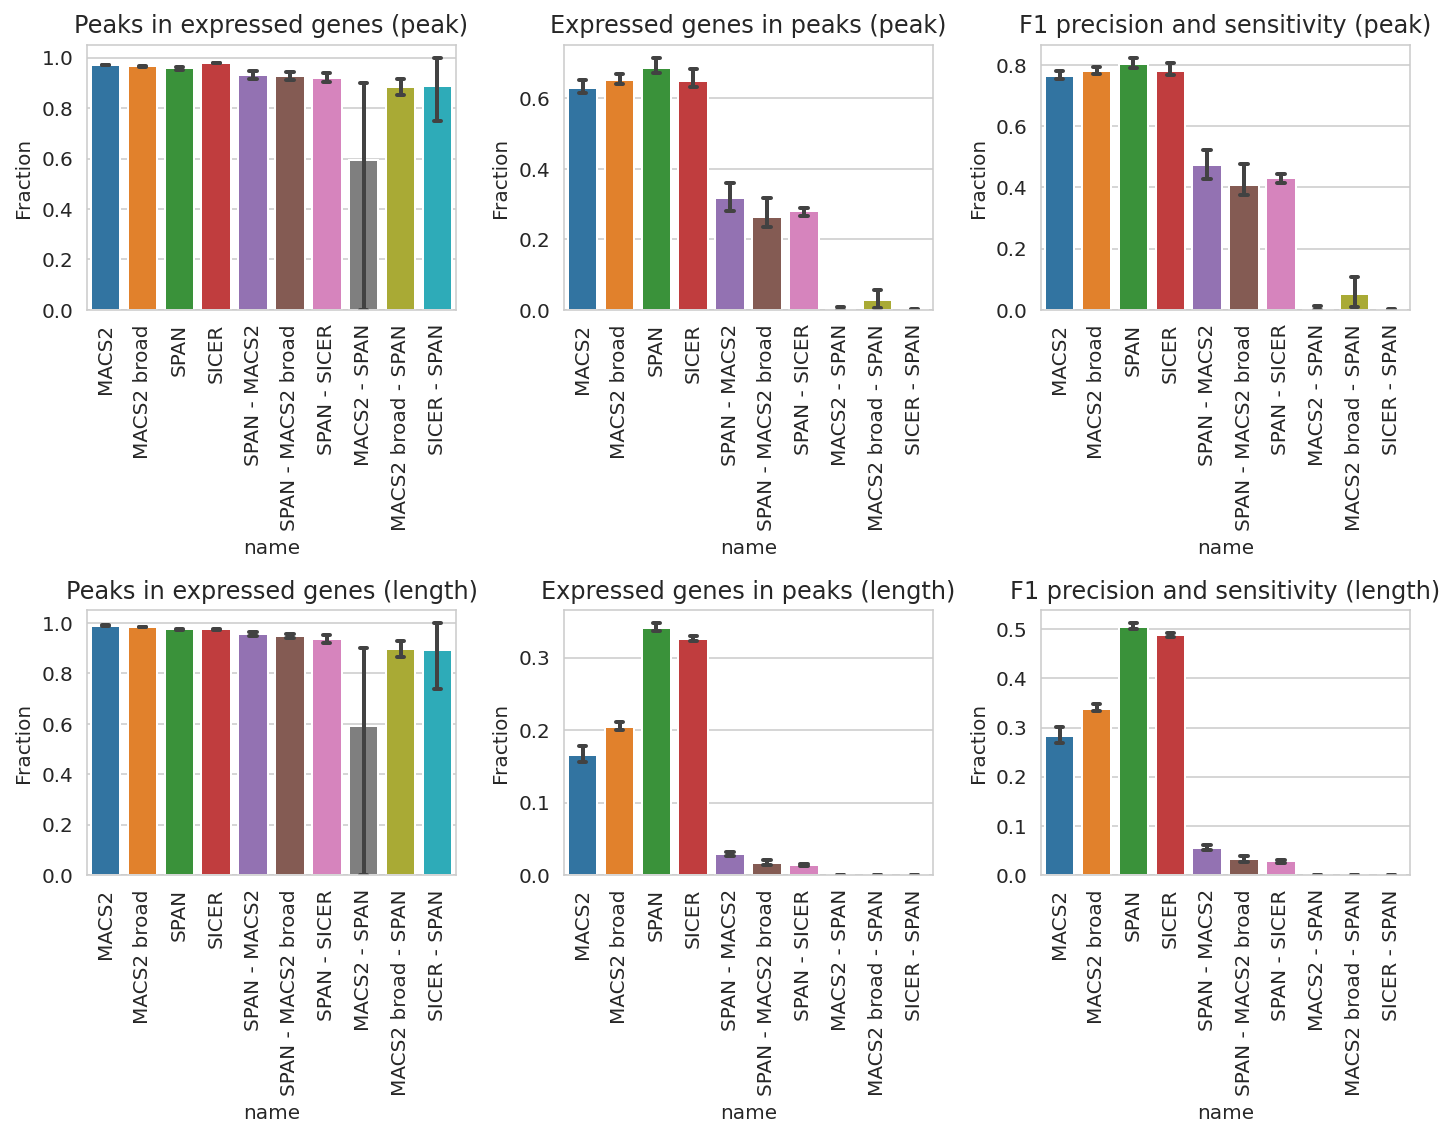

In [33]:
plt.figure(figsize=(10, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'Expressed genes in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

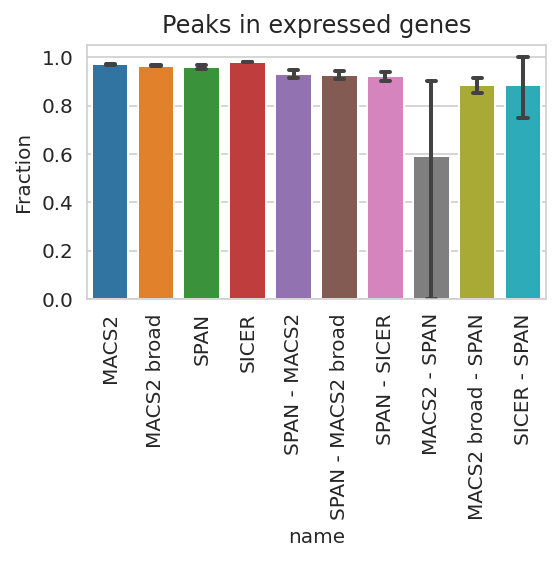

In [34]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks in expressed genes')
sns.barplot(data=t[(t['benchmark'] == 'peak') & (t['type'] == 'precision')], x='name', y='value',
            capsize=.2, errwidth=2, ax=ax,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                   ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_peaks_in_genes.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Venn diagram

In [35]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles


def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)


num_format(1.3e10, True)

VENN2_SUBSETS = ['1', '2', '1,2']
VENN2_LABELS = ['10', '01', '11']


def venn2_overlap(ax, peaks1, peaks2, overlap12, overlap21, name1, name2,
                  show_names=True, show_numbers=True, engineer=False, add_proportion=False,
                  set_font=15, subset_font=10):
    max_peaks = max(peaks1, peaks2)
    avg_overlap = (overlap12 + overlap21) / 2
    # Tweak subsets to avoid empty areas
    if show_numbers:
        subsets = (
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks1 - overlap12)) if peaks1 > overlap12 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks2 - overlap21)) if peaks2 > overlap21 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, avg_overlap))
        )
    else:
        subsets = (peaks1 - overlap12, peaks2 - overlap21, avg_overlap)
    v = venn2(subsets=subsets, set_labels=(name1, name2), alpha=0.3, ax=ax)
    venn2_circles(subsets=subsets, color='grey', linewidth=1.0, ax=ax)

    if overlap12 != 0 and overlap21 != 0:
        if overlap12 > overlap21:
            prop = f'{overlap12 / overlap21:.1f} : 1'
        else:
            prop = f'1 : {overlap21 / overlap12:.1f}'
        prop = prop.replace('.0', '')  # Cosmetics
    else:
        prop = ''

    if show_numbers:
        v.get_label_by_id('10').set_text(num_format(peaks1 - overlap12, engineer))
        v.get_label_by_id('01').set_text(num_format(peaks2 - overlap21, engineer))
        if add_proportion:
            v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
        else:
            v.get_label_by_id('11').set_text(num_format(avg_overlap, engineer))
    print(f'{name1}: {peaks1 - overlap12}')
    print(f'{name2}: {peaks2 - overlap21}')
    print(f'overlap: {overlap12} : {overlap21}, {prop}')
    for label in v.set_labels:
        if label is not None:
            if show_names:
                label.set_fontsize(set_font)
            else:
                label.set_text('')
    for label in v.subset_labels:
        if label is not None:
            label.set_fontsize(subset_font)
    if not show_numbers:
        for l in VENN2_LABELS:
            label = v.get_label_by_id(l)
            if label is not None:
                label.set_text('')


VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']


def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_names=True, show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets = (v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    venn3_circles(subsets=subsets, color='grey', linewidth=1.0, ax=ax)
    for label in v.set_labels:
        if label is not None:
            if show_names:
                label.set_fontsize(set_font)
            else:
                label.set_text('')
    for label in v.subset_labels:
        if label is not None:
            label.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

  0%|          | 0/1 [00:00<?, ?it/s]

BCell
BCell Venn diagrams of SPAN vs other tools (peaks)
SPAN: 16200
MACS2: 115
overlap: 26493 : 177841, 1 : 6.7
SPAN: 11351
MACS2 broad: 409
overlap: 31342 : 152093, 1 : 4.9
SPAN: 13742
SICER: 8
overlap: 28951 : 31854, 1 : 1.1


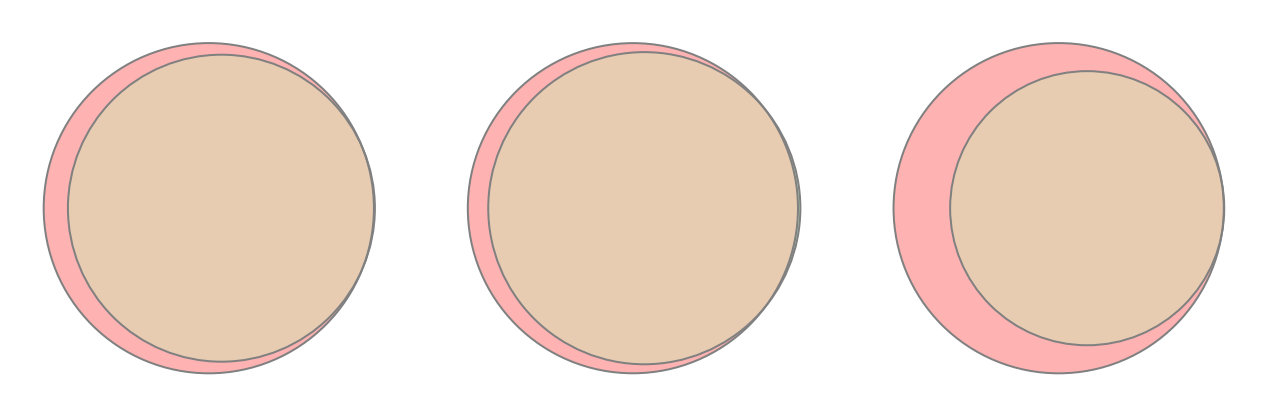

BCell Venn diagrams of Expressed genes vs tools (peaks)
Expressed genes: 5728
MACS2: 5379
overlap: 9393 : 172577, 1 : 18.4
Expressed genes: 5436
MACS2 broad: 5377
overlap: 9685 : 147125, 1 : 15.2
Expressed genes: 5553
SICER: 679
overlap: 9568 : 31183, 1 : 3.3
Expressed genes: 4941
SPAN: 2015
overlap: 10180 : 40678, 1 : 4


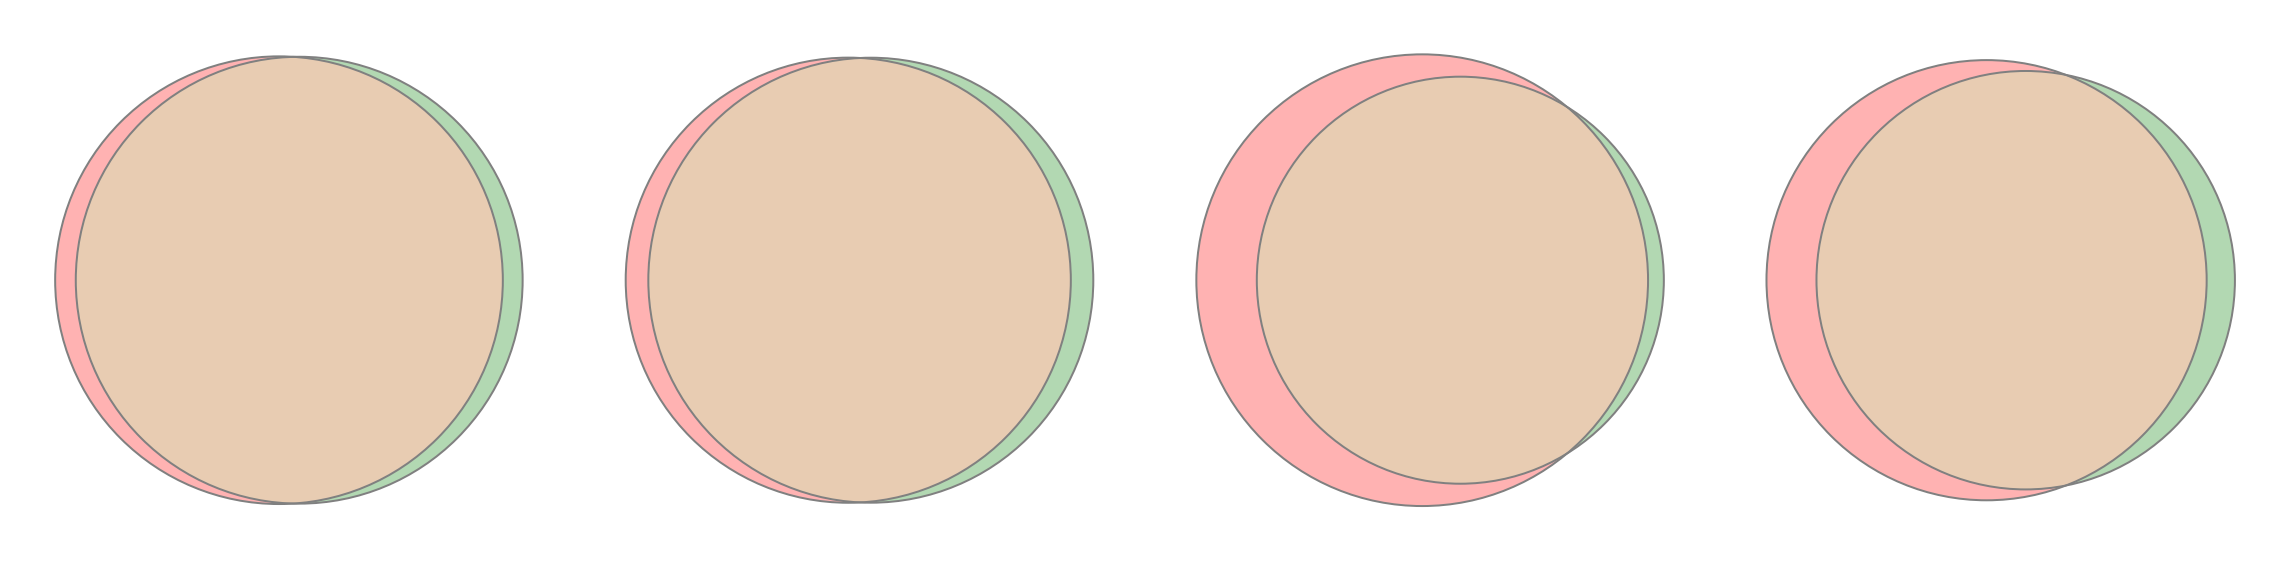

BCell Venn diagram of SPAN vs other tools and expressed genes (length)


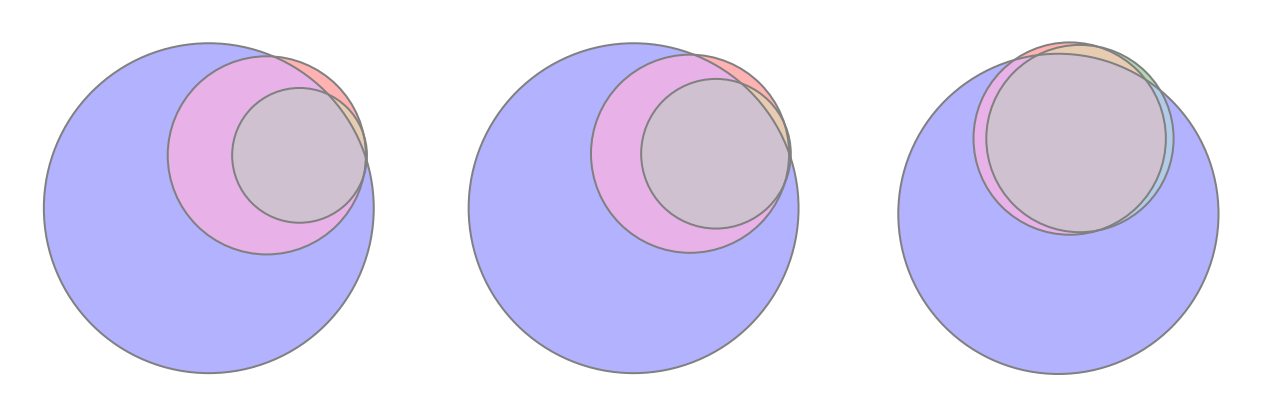

In [36]:
other_tools = list(sorted(filter(lambda t: t != 'SPAN', bench_df['name'].unique())))

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c in tqdm(['BCell']):
    if (c) not in EXPRESSION_BED:
        continue
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[(c)])
    expr_genes = lines(expr_file)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    span_peaks = lines(span_file)
    span_len = int(bedl(span_file).sum())
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())

    print(f'{c} Venn diagrams of SPAN vs other tools (peaks)')
    plt.figure(figsize=(3 * len(other_tools), 3))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -u > {tf}
        span_overlap = lines(tf)
        !bedtools intersect -b {span_file} -a {peaks_file} -wa -u > {tf}
        other_overlap = lines(tf)
        venn2_overlap(axs[i], span_peaks, peaks_number, span_overlap, other_overlap, 'SPAN', tool,
                      show_names=False, show_numbers=False, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print(f'{c} Venn diagrams of Expressed genes vs tools (peaks)')
    plt.figure(figsize=(4 * (len(other_tools) + 1), 4))
    axs = [plt.subplot(1, len(other_tools) + 1, i + 1) for i in range(len(other_tools) + 1)]
    for i, tool in enumerate(other_tools + ['SPAN']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {expr_file} -b {peaks_file} -wa -u > {tf}
        expr_overlap = lines(tf)
        !bedtools intersect -b {expr_file} -a {peaks_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        venn2_overlap(axs[i], expr_genes, peaks_number, expr_overlap, peaks_overlap, 'Expressed genes', tool,
                      show_names=False, show_numbers=False, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print(f'{c} Venn diagram of SPAN vs other tools and expressed genes (length)')
    plt.figure(figsize=(3 * len(other_tools), 3))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            for o in VENN3_SUBSETS
        ], 'SPAN', tool, 'Expressed genes', show_names=False, show_numbers=False, engineer=True)

    plt.tight_layout()
    plt.show()

## Compare genes expression overlapping peaks

In [37]:
import tempfile

tf = tempfile.mktemp()

ts = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])

        for overlap, overlap_param in [
            ('1bp', ''),
            ('50%', ' -f 0.5 '),
        ]:
            !bedtools intersect -a {expr_file} -b {peaks_file} -wa -u {overlap_param} > {tf}
            tf_expression = pd.read_csv(tf, sep='\t',
                                        names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'expression']
                                        )[['expression']].copy()
            tf_expression['name'] = tool
            tf_expression['overlap'] = overlap
            ts.append(tf_expression)

peaks_expression = pd.concat(ts).reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


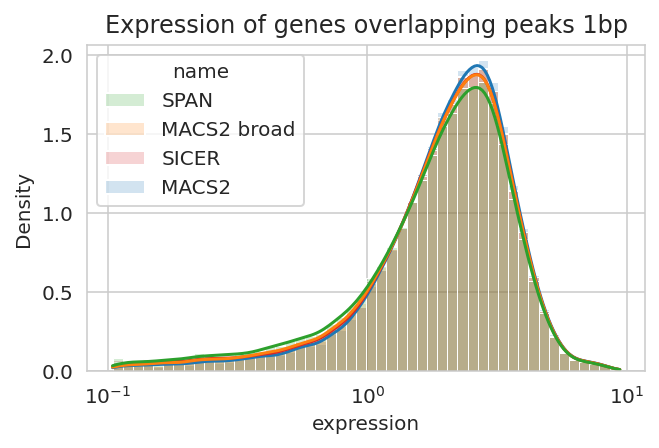

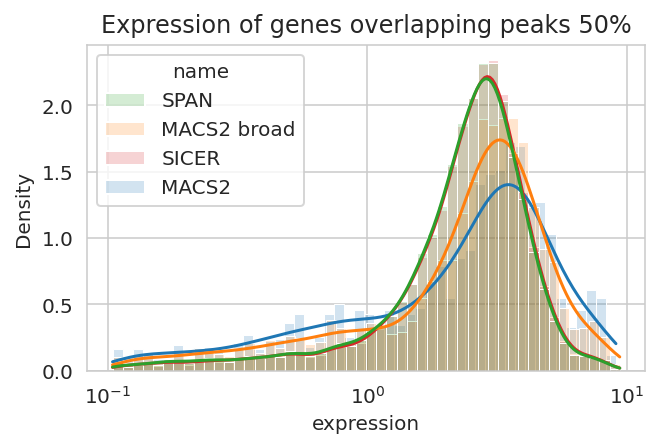

In [38]:
for overlap in peaks_expression['overlap'].unique():
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    g_results = sns.histplot(data=peaks_expression[peaks_expression['overlap']==overlap], x='expression', hue='name', ax=ax,
                             bins=50, stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE)
    g_results.set(xscale='log')
    ax.title.set_text(f'Expression of genes overlapping peaks {overlap}')
    plt.show()

## Compare ratio of peaks vs genes

In [39]:
import tempfile

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'tool', 'genes', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        !bedtools intersect -a {expr_file} -b {peaks_file} -wa -wb > {tf}
        expr_cols = len(pd.read_csv(expr_file, sep='\t', header=None, nrows=1).columns)
        try:
            tf_expression = pd.read_csv(tf, sep='\t', header=None)
            genes = len(tf_expression.groupby([0, 1, 2]).count())
            peaks = len(tf_expression.groupby([expr_cols, expr_cols + 1, expr_cols + 2]).count())
            ratio_df.loc[len(ratio_df)] = (c, tool, genes, peaks)
        except:
            pass
ratio_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell         tool  genes   peaks
0      BCell         SPAN  10180   40678
1      BCell  MACS2 broad   9685  147125
2      BCell        SICER   9568   31183
3      BCell        MACS2   9393  172577
4      TCell         SPAN  10313   45080
5      TCell  MACS2 broad   9923  155914
6      TCell        SICER   9664   31827
7      TCell        MACS2   9416  178040
8   Monocyte         SPAN   9674   40815
9   Monocyte  MACS2 broad   9070  102429
10  Monocyte        SICER   9257   31140
11  Monocyte        MACS2   8814  123404

In [40]:
ratio_df['peaks_to_genes'] = ratio_df['peaks'] / ratio_df['genes']
ratio_df.sort_values(by=['tool'], inplace=True)

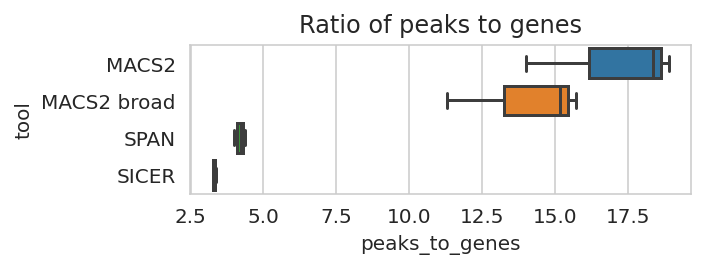

In [41]:
plt.figure(figsize=(5, 2))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df, x='peaks_to_genes', y='tool', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.title.set_text('Ratio of peaks to genes')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_ratios.pdf', bbox_inches='tight', dpi=300)
plt.show()

# H3K36me3 TPM benchmark

In [42]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
expr_file = tempfile.mktemp()

benchmark_tpm_df = pd.DataFrame(
    columns=['cell', 'tpm', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'overlap', 'tool'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = pd.read_csv(EXPRESSION_TSV[c], sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)

    for tpm in np.linspace(0, 0.5, 6):
        print('Processing TMP', tpm)
        full_df[full_df['LTPM'] > tpm].to_csv(expr_file, sep='\t', index=False, header=None)
        expr_file = sorted_file(expr_file)
        genes = lines(expr_file)
        for tool in set(df_fdr_peaks['tool']):
            t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                             (df_fdr_peaks['modification'] == 'H3K36me3') &
                             (df_fdr_peaks['cell'] == c)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            peaks = lines(peaks_file)
            for overlap, overlap_param in [
                ('1bp', ''),
                ('50%', ' -f 0.5 ')
            ]:
                !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
                peaks_overlap = lines(tf)
                !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
                genes_overlap = lines(tf)
                benchmark_tpm_df.loc[len(benchmark_tpm_df)] = \
                    (c, tpm, genes, peaks_file, peaks, peaks_overlap, genes_overlap, overlap, tool)

benchmark_tpm_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
TCell
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
Monocyte
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5


cell  tpm  genes        peaks_file   peaks      pg     gp overlap  \
0       BCell  0.0  21690  /tmp/tmpkp9vtrcc   42693   40955  11509     1bp   
1       BCell  0.0  21690  /tmp/tmpkp9vtrcc   42693   40433   4948     50%   
2       BCell  0.0  21690  /tmp/tmpkxsu2y7t  152502  147805  10797     1bp   
3       BCell  0.0  21690  /tmp/tmpkxsu2y7t  152502  146929   1196     50%   
4       BCell  0.0  21690  /tmp/tmpu2refvmv   31862   31269  10751     1bp   
..        ...  ...    ...               ...     ...     ...    ...     ...   
139  Monocyte  0.5  10587  /tmp/tmpjb8z0ke5  105833   98558    988     50%   
140  Monocyte  0.5  10587  /tmp/tmpr306f0is   31796   29874   8867     1bp   
141  Monocyte  0.5  10587  /tmp/tmpr306f0is   31796   29471   3448     50%   
142  Monocyte  0.5  10587  /tmp/tmp624bg2x2  127115  120389   8576     1bp   
143  Monocyte  0.5  10587  /tmp/tmp624bg2x2  127115  119671    586     50%   

            tool  
0           SPAN  
1           SPAN  
2    MACS2 broad  
3    MACS2 broad  
4          SICER  
..           ...  
139  MACS2 broad  
140        SICER  
141        SICER  
142        MACS2  
143        MACS2  

[144 rows x 9 columns]

In [43]:
benchmark_tpm_df['p'] = (benchmark_tpm_df['pg'] + benchmark_tpm_df['gp']) / 2
benchmark_tpm_df['precision'] = [d(x, y) for x, y in zip(benchmark_tpm_df['pg'], benchmark_tpm_df['peaks'])]
benchmark_tpm_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_tpm_df['gp'], benchmark_tpm_df['genes'])]
benchmark_tpm_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_tpm_df['sensitivity'], benchmark_tpm_df['precision'])]
benchmark_tpm_df

cell  tpm  genes        peaks_file   peaks      pg     gp overlap  \
0       BCell  0.0  21690  /tmp/tmpkp9vtrcc   42693   40955  11509     1bp   
1       BCell  0.0  21690  /tmp/tmpkp9vtrcc   42693   40433   4948     50%   
2       BCell  0.0  21690  /tmp/tmpkxsu2y7t  152502  147805  10797     1bp   
3       BCell  0.0  21690  /tmp/tmpkxsu2y7t  152502  146929   1196     50%   
4       BCell  0.0  21690  /tmp/tmpu2refvmv   31862   31269  10751     1bp   
..        ...  ...    ...               ...     ...     ...    ...     ...   
139  Monocyte  0.5  10587  /tmp/tmpjb8z0ke5  105833   98558    988     50%   
140  Monocyte  0.5  10587  /tmp/tmpr306f0is   31796   29874   8867     1bp   
141  Monocyte  0.5  10587  /tmp/tmpr306f0is   31796   29471   3448     50%   
142  Monocyte  0.5  10587  /tmp/tmp624bg2x2  127115  120389   8576     1bp   
143  Monocyte  0.5  10587  /tmp/tmp624bg2x2  127115  119671    586     50%   

            tool        p  precision  sensitivity        f1  
0           SPAN  26232.0   0.959291     0.530613  0.683282  
1           SPAN  22690.5   0.947064     0.228124  0.367682  
2    MACS2 broad  79301.0   0.969200     0.497787  0.657750  
3    MACS2 broad  74062.5   0.963456     0.055141  0.104311  
4          SICER  21010.0   0.981388     0.495666  0.658664  
..           ...      ...        ...          ...       ...  
139  MACS2 broad  49773.0   0.931260     0.093322  0.169644  
140        SICER  19370.5   0.939552     0.837537  0.885616  
141        SICER  16459.5   0.926878     0.325682  0.482001  
142        MACS2  64482.5   0.947087     0.810050  0.873225  
143        MACS2  60128.5   0.941439     0.055351  0.104555  

[144 rows x 13 columns]

In [44]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))

PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [45]:
import plotly.graph_objects as go

def plot_tpm(benchmark_tpm_df, zoom=False):
    tools_legend_shown = set()
    fig = go.Figure()
    for overlap in benchmark_tpm_df['overlap'].unique():
        marker = 'square' if overlap == '1bp' else  'circle' if overlap == '50%' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_tpm_df[(benchmark_tpm_df['cell'] == c) &
                               (benchmark_tpm_df['overlap'] == overlap) &
                               (benchmark_tpm_df['tool'] == t)]
            if len(dft) == 0:
                continue
            fig.add_trace(go.Scatter(
                x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
                hovertext=dft['tpm'].astype(str) + ' ' + t, marker_symbol=[marker] * len(dft),
                showlegend=t not in tools_legend_shown,
                marker_color=PLOTLY_TOOLS_PALETTE[t],
                opacity=0.3
            ))
            tools_legend_shown.add(t)


    for overlap in set(benchmark_tpm_df['overlap']):
        marker = 'square' if overlap == '1bp' else  'circle' if overlap == '50%' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_tpm_df[(benchmark_tpm_df['cell'] == c) &
                                   (benchmark_tpm_df['overlap'] == overlap) &
                                   (benchmark_tpm_df['tool'] == t) &
                                   (benchmark_tpm_df['tpm'] == 0.1)]
            if len(dft) == 0:
                continue
            fig.add_trace(
                go.Scatter(
                    mode='markers',
                    x=dft["precision"], y=dft["sensitivity"],
                    name=t,
                    marker=dict(color='white', size=10, line=dict(width=1), symbol=marker),
                    showlegend=False,
                    hovertext=dft['tpm'].astype(str) + ' ' + t
                )
            )

    fig.update_xaxes(title='Peaks overlapping active genes (precision)')
    fig.update_yaxes(title='Active genes overlapping peaks (sensitivity)')
    if not zoom:
        fig.update_xaxes(range=[-0.1, 1.1])
        fig.update_yaxes(range=[-0.1, 1.1])

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600,)
    fig.show()


In [46]:
plot_tpm(benchmark_tpm_df[benchmark_tpm_df['overlap'] == '1bp'], zoom=True)

In [47]:
plot_tpm(benchmark_tpm_df[benchmark_tpm_df['overlap'] == '50%'])

# Coverage

In [7]:
IMMUNE_HG38_PATH_BW = PATH + '/bw'

def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [8]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K36me3')
bws_df.sample(3)

  0%|          | 0/17 [00:00<?, ?it/s]

file modification      cell
0  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...     H3K36me3     BCell
1  /home/jetbrains/data/2023_Immune/bw/TCell_H3K3...     H3K36me3     TCell
2  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...     H3K36me3  Monocyte

In [9]:
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
bws_control_df.sample(3)

  0%|          | 0/17 [00:00<?, ?it/s]

file modification      cell
0  /home/jetbrains/data/2023_Immune/bw/TCell_Cont...      Control     TCell
1  /home/jetbrains/data/2023_Immune/bw/Monocyte_C...      Control  Monocyte
2  /home/jetbrains/data/2023_Immune/bw/BCell_Cont...      Control     BCell

In [10]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [11]:
import tempfile
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K36me3') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
MACS2 broad /tmp/tmp6iphek7k /home/jetbrains/data/2023_Immune/bw/BCell_H3K36me3_hg38_ENCFF207YSM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 /tmp/tmp69bqnfj7 /home/jetbrains/data/2023_Immune/bw/BCell_H3K36me3_hg38_ENCFF207YSM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SICER /tmp/tmp_qkq97ig /home/jetbrains/data/2023_Immune/bw/BCell_H3K36me3_hg38_ENCFF207YSM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SPAN /tmp/tmp94dc91pa /home/jetbrains/data/2023_Immune/bw/BCell_H3K36me3_hg38_ENCFF207YSM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
TCell
MACS2 broad /tmp/tmpnis73ost /home/jetbrains/data/2023_Immune/bw/TCell_H3K36me3_hg38_ENCFF783YIM.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
MACS2 /tmp/tmphzdfw6xv /home/jetbrains/data/2023_Immune/bw/TCell_H3K36me3_hg38_ENCFF783YIM.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566

cell                                            bw_file         tool  \
0      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...  MACS2 broad   
1      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...        MACS2   
2      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...        SICER   
3      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...         SPAN   
4      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K3...  MACS2 broad   
5      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K3...        MACS2   
6      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K3...        SICER   
7      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K3...         SPAN   
8   Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...  MACS2 broad   
9   Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...        MACS2   
10  Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...        SICER   
11  Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...         SPAN   

          peaks_file   peaks     length  reads_in_peaks     all_reads  \
0   /tmp/tmp6iphek7k  152502  217568779    4.121087e+07  8.492705e+07   
1   /tmp/tmp69bqnfj7  177956  176542432    3.649336e+07  8.492705e+07   
2   /tmp/tmp_qkq97ig   31862  361660938    5.172490e+07  8.492705e+07   
3   /tmp/tmp94dc91pa   42693  381441369    5.330747e+07  8.492705e+07   
4   /tmp/tmpnis73ost  161765  209812830    4.200677e+07  8.494429e+07   
5   /tmp/tmphzdfw6xv  183613  161790798    3.655376e+07  8.494429e+07   
6   /tmp/tmpx2rnzdoa   32491  342597109    5.126316e+07  8.494429e+07   
7   /tmp/tmpo9udjvqm   47042  355718056    5.242774e+07  8.494429e+07   
8   /tmp/tmpv9jp9h1b  105833  199110989    5.072391e+07  8.495855e+07   
9   /tmp/tmpnxn66sjv  127115  167040107    4.660167e+07  8.495855e+07   
10  /tmp/tmpiiui0zzz   31796  306861404    5.980762e+07  8.495855e+07   
11  /tmp/tmptyd6b_1q   42160  320118408    6.093910e+07  8.495855e+07   

    control_reads_in_peaks  control_all_reads  
0             7.360498e+06       8.482853e+07  
1             5.873006e+06       8.482853e+07  
2             1.278876e+07       8.481521e+07  
3             1.335214e+07       8.484955e+07  
4             7.125270e+06       8.482866e+07  
5             5.515389e+06       8.482866e+07  
6             1.183700e+07       8.482415e+07  
7             1.222307e+07       8.488870e+07  
8             6.396366e+06       8.479462e+07  
9             5.427079e+06       8.479462e+07  
10            1.025190e+07       8.478965e+07  
11            1.070105e+07       8.480613e+07

In [12]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

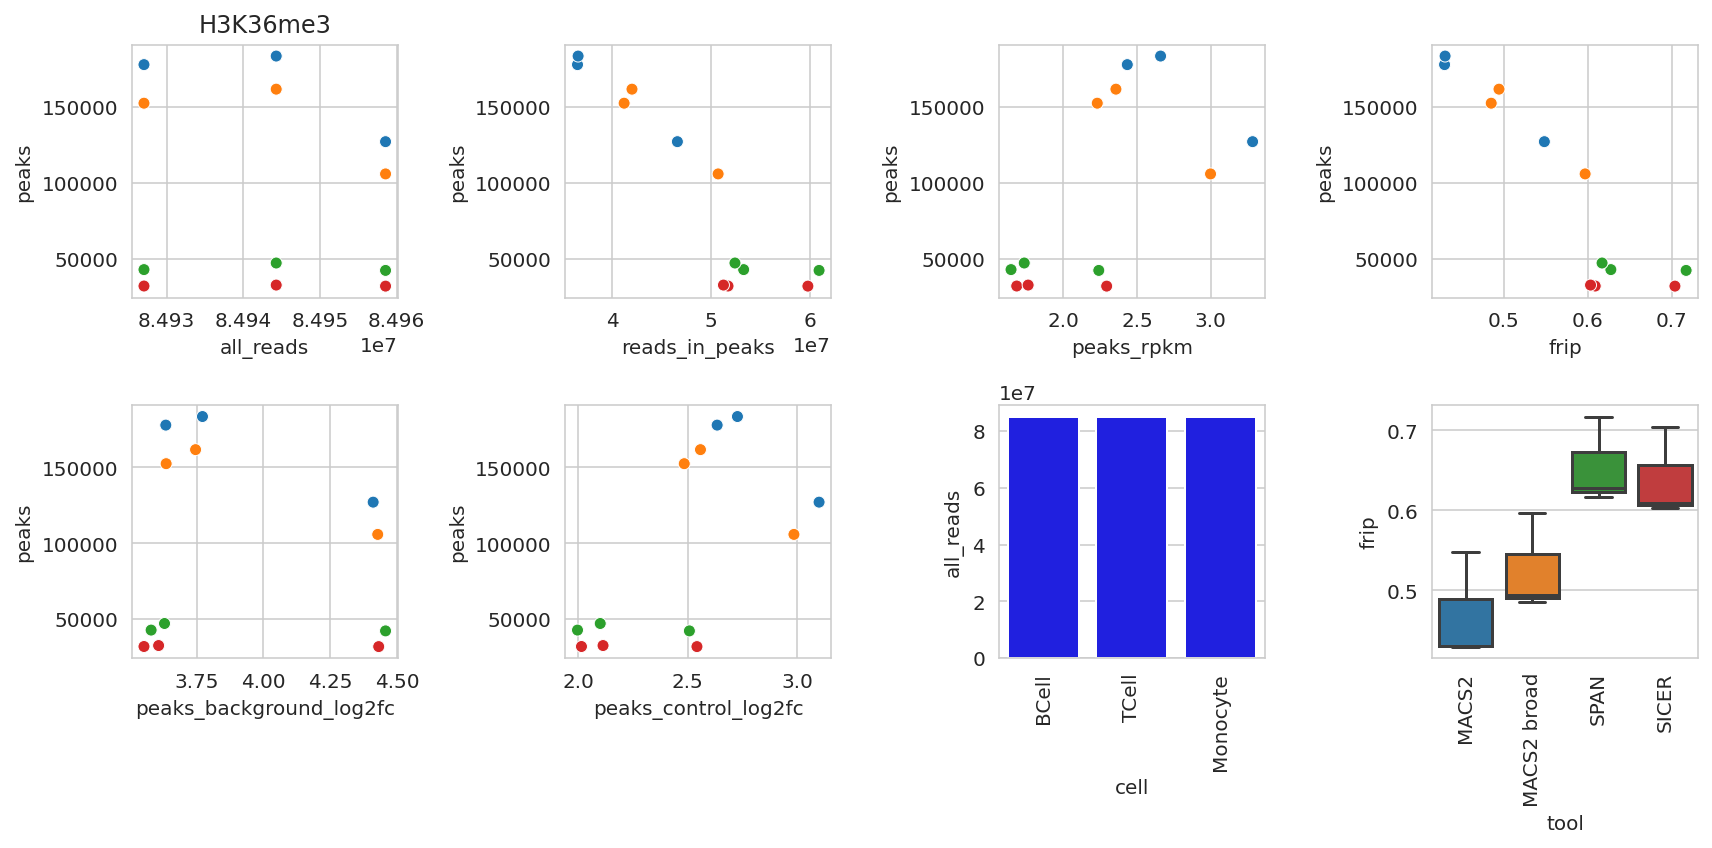

In [13]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K36me3')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{PATH}/pics/H3K36me3_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
frip_df.to_csv(f'{PATH}/pics/H3K36me3_frip.csv.gz', index=None, compression='gzip')

# Peaks density

In [15]:
import pyBigWig
import tempfile

tf = tempfile.mktemp()

coverage_data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = bws_df[(bws_df['modification'] == 'H3K36me3') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K36me3', c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K36me3', c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K36me3', c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K36me3', c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


modification      cell                name                  position  \
2476948     H3K36me3  Monocyte        SPAN - MACS2  chr2:143471839-143475473   
160267      H3K36me3     BCell         MACS2 broad  chr1:113796575-113798178   
2427706     H3K36me3  Monocyte                SPAN    chr2:27909579-27917533   
2268668     H3K36me3  Monocyte               MACS2    chr5:31415516-31416814   
1796153     H3K36me3     TCell  SPAN - MACS2 broad     chr17:4351276-4351838   

         length     type   coverage  total_coverage  
2476948    3634  control  59.797463    8.480544e+07  
160267     1603  control  75.346529    8.482853e+07  
2427706    7954  control  34.881849    8.480613e+07  
2268668    1298  control  54.814369    8.479462e+07  
1796153     562  control  14.123442    8.488420e+07

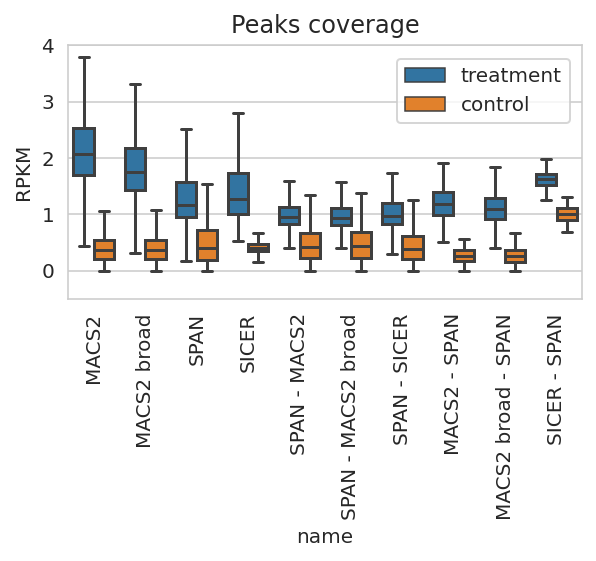

In [16]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-0.5, 4)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compute BAM reads

In [15]:
def load_bams(path, m):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'mapped_reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        rep = 'rep1' if 'rep1' in f else 'rep2'
        if cell and rep and m in f:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, m, cell, rep, reads)
    return df_bams

bams_df = load_bams(PATH + '/bams', 'H3K36me3')
bams_df

  0%|          | 0/35 [00:00<?, ?it/s]

bam_file modification      cell  \
0  /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K36me3     BCell   
1  /home/jetbrains/data/2023_Immune/bams/TCell_H3...     H3K36me3     TCell   
2  /home/jetbrains/data/2023_Immune/bams/Monocyte...     H3K36me3  Monocyte   

  replicate  mapped_reads  
0      rep2      22597809  
1      rep2      22349392  
2      rep2      20118416

In [16]:
t = pd.merge(frip_df, bams_df, left_on=['cell'], right_on=['cell'])

In [17]:
t['dataset'] = 'Immune'
t.to_csv('/tmp/immune.tsv', sep='\t', index=False)

# ChromHMM

In [58]:
CHROMHMM_MAP = {
    'BCell': PATH + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': PATH + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': PATH + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [59]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chrommm_df = pd.DataFrame(data, columns=['cell', 'name', 'peaks'] + CHROMM_STATES)
chrommm_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell                name   peaks  EnhA1  EnhA2  EnhBiv  EnhG1  EnhG2  \
0      BCell                SPAN   42693   4743   1588     121   3910   1382   
1      BCell         MACS2 broad  152502   5398   1460      73   6267   1958   
2      BCell               SICER   31862   4458   1546     100   3958   1378   
3      BCell               MACS2  177956   4770   1299      55   7351   2156   
4      BCell        SPAN - MACS2   16200   1047    235      41     47     22   
5      BCell        MACS2 - SPAN     115      4      1       2      0      0   
6      BCell  SPAN - MACS2 broad   11351    748    145      28     19     12   
7      BCell  MACS2 broad - SPAN     409     14      4       2      0      0   
8      BCell        SPAN - SICER   13742    697    128      42     49     17   
9      BCell        SICER - SPAN       8      1      0       0      0      0   
10     TCell                SPAN   47042   5926   2247     195   4032   1918   
11     TCell         MACS2 broad  161765   7692   1992     135   6794   3169   
12     TCell               SICER   32491   5395   2122     159   4051   1925   
13     TCell               MACS2  183613   6279   1568      69   8749   4096   
14     TCell        SPAN - MACS2   18910   1410    322      79     16      4   
15     TCell        MACS2 - SPAN      50      1      0       1      0      0   
16     TCell  SPAN - MACS2 broad   11094    856    175      41      1      1   
17     TCell  MACS2 broad - SPAN    1211     33      5      13      1      0   
18     TCell        SPAN - SICER   15000    921    209      54     11      4   
19     TCell        SICER - SPAN       9      1      0       0      0      0   
20  Monocyte                SPAN   42160   3679   1021     165   4240   1678   
21  Monocyte         MACS2 broad  105833   2292    643     103   5555   1909   
22  Monocyte               SICER   31796   3532    962     162   4219   1685   
23  Monocyte               MACS2  127115   1885    544      85   5946   1947   
24  Monocyte        SPAN - MACS2   18400    972    198      43    145     55   
25  Monocyte        MACS2 - SPAN       0      0      0       0      0      0   
26  Monocyte  SPAN - MACS2 broad   13761    740    143      29     87     38   
27  Monocyte  MACS2 broad - SPAN      58      1      0       0      0      0   
28  Monocyte        SPAN - SICER   11788    507     98      23     47     26   
29  Monocyte        SICER - SPAN      11      0      0       0      0      0   

    EnhWk   Het  ...  ReprPC  ReprPCWk  TssA  TssBiv  TssFlnk  TssFlnkD  \
0   11468  5241  ...     730       651   415      16     2931      1377   
1   15057  6232  ...     600       492   219       5     2025       787   
2   10661  4050  ...     386       337   789      25     3598      1811   
3   13477  5177  ...     426       354   179       3     1615       585   
4    2430  1606  ...     359       329    22       4      294        96   
5       8    11  ...       9         7     0       0        1         1   
6    1625  1087  ...     258       239    14       3      187        56   
7      36    36  ...      18        15     0       0        7         3   
8    1710  1343  ...     360       327    11       2      183        62   
9       1     2  ...       0         0     0       0        0         0   
10  10978  3016  ...    1906      1784   347      38     3562      1271   
11  13366  2917  ...    2123      1917   192      27     2724       703   
12   9823  2433  ...    1044       968   635      45     4192      1655   
13  10220  1916  ...    1185      1035   145      14     1977       467   
14   2623   969  ...     973       932    36       7      531       150   
15      0     2  ...       4         4     0       0        0         0   
16   1506   503  ...     547       522    23       3      318        94   
17     64    42  ...     115       104     2       2       10         3   
18   1738   674  ...     916       868    20       5      332        94   
19      2     1  ...       

In [60]:
chrommm_df_mean = chrommm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
chrommm_df_mean

EnhA1        EnhA2      EnhBiv        EnhG1  \
name                                                                    
MACS2               4311.333333  1137.000000   69.666667  7348.666667   
MACS2 broad         5127.333333  1365.000000  103.666667  6205.333333   
SPAN                4782.666667  1618.666667  160.333333  4060.666667   
SICER               4461.666667  1543.333333  140.333333  4076.000000   
SPAN - MACS2        1143.000000   251.666667   54.333333    69.333333   
SPAN - MACS2 broad   781.333333   154.333333   32.666667    35.666667   
SPAN - SICER         708.333333   145.000000   39.666667    35.666667   
MACS2 - SPAN           1.666667     0.333333    1.000000     0.000000   
MACS2 broad - SPAN    16.000000     3.000000    5.000000     0.333333   
SICER - SPAN           0.666667     0.000000    0.000000     0.000000   

                          EnhG2         EnhWk          Het         Quies  \
name                                                                       
MACS2               2733.000000   9300.333333  2663.666667  26200.333333   
MACS2 broad         2345.333333  11279.000000  3479.000000  35220.333333   
SPAN                1659.333333  10306.000000  3405.333333  22708.333333   
SICER               1662.666667   9423.000000  2676.666667  14585.333333   
SPAN - MACS2          27.000000   2503.666667  1124.000000  11358.666667   
SPAN - MACS2 broad    17.000000   1665.333333   712.333333   7601.333333   
SPAN - SICER          15.666667   1563.333333   820.000000   8663.666667   
MACS2 - SPAN           0.000000      2.666667     4.333333     35.000000   
MACS2 broad - SPAN     0.000000     34.333333    26.666667    355.000000   
SICER - SPAN           0.000000      1.666667     1.000000      7.666667   

                         ReprPC    ReprPCWk        TssA     TssBiv  \
name                                                                 
MACS2                627.333333  518.666667  133.666667  19.666667   
MACS2 broad         1022.666667  880.000000  166.000000  27.000000   
SPAN                1021.666667  912.666667  305.000000  43.333333   
SICER                581.666667  509.666667  533.333333  46.000000   
SPAN - MACS2         506.333333  469.333333   24.333333   8.666667   
SPAN - MACS2 broad   313.333333  287.666667   17.000000   5.333333   
SPAN - SICER         465.333333  428.000000   13.333333   5.333333   
MACS2 - SPAN           4.333333    3.666667    0.000000   0.000000   
MACS2 broad - SPAN    44.666667   40.000000    0.666667   0.666667   
SICER - SPAN           0.000000    0.000000    0.000000   0.000000   

                        TssFlnk     TssFlnkD     TssFlnkU             Tx  \
name                                                                       
MACS2               1378.333333   393.666667  1080.333333  121524.666667   
MACS2 broad         1815.000000   555.666667  1417.333333   91297.666667   
SPAN                2621.000000   995.333333  2046.000000   21184.333333   
SICER               3109.666667  1281.666667  2474.000000   19665.000000   
SPAN - MACS2         347.666667    97.666667   276.666667    4190.333333   
SPAN - MACS2 broad   224.666667    61.000000   183.000000    2796.000000   
SPAN - SICER         209.333333    58.333333   165.333333    2754.000000   
MACS2 - SPAN           0.333333     0.333333     0.000000       6.000000   
MACS2 broad - SPAN     5.666667     2.000000     4.333333      75.666667   
SICER - SPAN           0.000000     0.000000     0.000000       0.666667   

                            TxWk  ZNF_Rpts  
name                                        
MACS2               84283.000000       0.0  
MACS2 broad         77074.000000       0.0  
SPAN                20665.666667       0.0  
SICER               19269.666667       0.0  
SPAN - MACS2         4098.666667       0.0  
SPAN - MACS2 broad   2726.666667       0.0  
SPAN - SICER         2669.666667       0.0  
MACS2 - SPAN            5.333333       0.0  
MACS2 broad - SPAN     73.333333

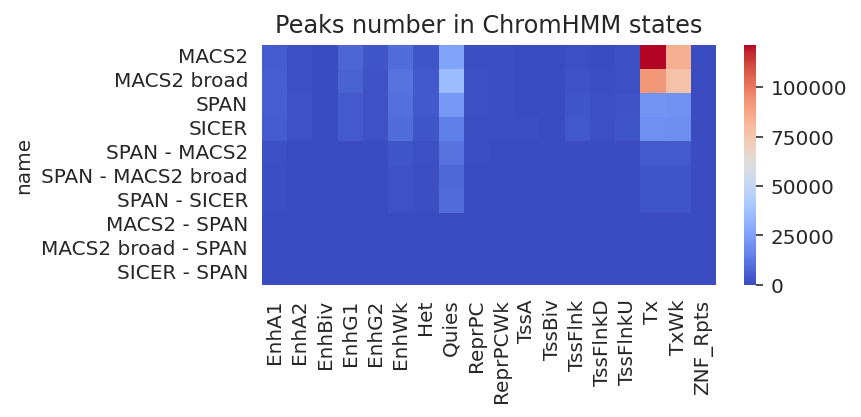

In [61]:
plt.figure(figsize=(6, 3))
sns.heatmap(chrommm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [62]:
chromhmm_rel_df = chrommm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chrommm_df[state], chrommm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

EnhA1     EnhA2    EnhBiv     EnhG1     EnhG2  \
name                                                                   
MACS2               0.025277  0.006706  0.000451  0.045245  0.016580   
MACS2 broad         0.034868  0.009321  0.000762  0.045194  0.016822   
SPAN                0.108110  0.036393  0.003631  0.092621  0.037648   
SICER               0.139015  0.048029  0.004376  0.127198  0.051830   
SPAN - MACS2        0.064006  0.014098  0.003015  0.003876  0.001520   
SPAN - MACS2 broad  0.065610  0.012980  0.002757  0.002695  0.001303   
SPAN - SICER        0.051710  0.010520  0.002869  0.002762  0.001236   
MACS2 - SPAN        0.018261  0.002899  0.012464  0.000000  0.000000   
MACS2 broad - SPAN  0.026240  0.004636  0.005208  0.000275  0.000000   
SICER - SPAN        0.078704  0.000000  0.000000  0.000000  0.000000   

                       EnhWk       Het     Quies    ReprPC  ReprPCWk  \
name                                                                   
MACS2               0.054822  0.015530  0.155202  0.003660  0.002980   
MACS2 broad         0.077505  0.023689  0.243403  0.006773  0.005753   
SPAN                0.234310  0.077780  0.514952  0.022597  0.020120   
SICER               0.293924  0.083549  0.454765  0.018051  0.015805   
SPAN - MACS2        0.140766  0.064565  0.637756  0.027926  0.025861   
SPAN - MACS2 broad  0.138145  0.060284  0.634423  0.027282  0.025173   
SPAN - SICER        0.115221  0.060081  0.638464  0.032481  0.029737   
MACS2 - SPAN        0.023188  0.045217  0.447536  0.052754  0.046957   
MACS2 broad - SPAN  0.064198  0.052395  0.684180  0.052071  0.046599   
SICER - SPAN        0.176347  0.120370  0.830387  0.000000  0.000000   

                        TssA    TssBiv   TssFlnk  TssFlnkD  TssFlnkU  \
name                                                                   
MACS2               0.000800  0.000141  0.008038  0.002282  0.006312   
MACS2 broad         0.001148  0.000221  0.012231  0.003726  0.009566   
SPAN                0.006909  0.000995  0.058956  0.022430  0.045987   
SICER               0.016614  0.001436  0.096782  0.039899  0.076985   
SPAN - MACS2        0.001359  0.000477  0.019359  0.005471  0.015367   
SPAN - MACS2 broad  0.001441  0.000420  0.019140  0.005268  0.015530   
SPAN - SICER        0.000966  0.000414  0.015012  0.004130  0.011900   
MACS2 - SPAN        0.000000  0.000000  0.002899  0.002899  0.000000   
MACS2 broad - SPAN  0.000551  0.000551  0.008458  0.003271  0.006277   
SICER - SPAN        0.000000  0.000000  0.000000  0.000000  0.000000   

                          Tx      TxWk  ZNF_Rpts  
name                                              
MACS2               0.755314  0.522778       0.0  
MACS2 broad         0.664359  0.559103       0.0  
SPAN                0.484057  0.472084       0.0  
SICER               0.613903  0.601541       0.0  
SPAN - MACS2        0.233818  0.228646       0.0  
SPAN - MACS2 broad  0.224451  0.219100       0.0  
SPAN - SICER        0.209158  0.202582       0.0  
MACS2 - SPAN        0.067246  0.061449       0.0  
MACS2 broad - SPAN  0.117295  0.113209       0.0  
SICER - SPAN        0.060606  0.060606       0.0

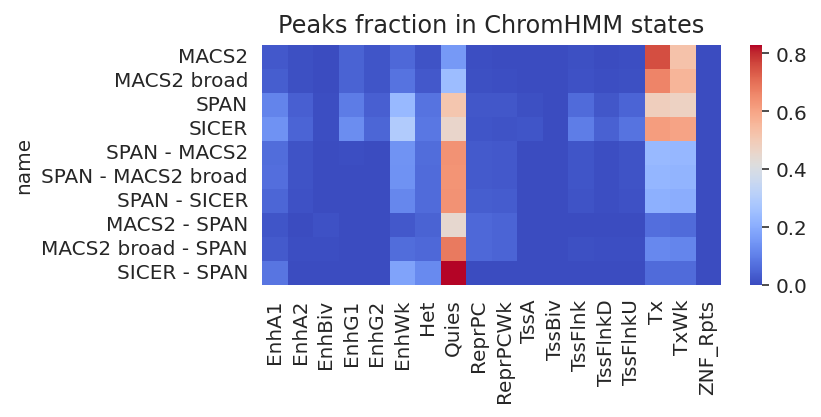

In [63]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K36me3_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()